In [142]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import dijkstra
from scipy.sparse.linalg import norm, eigen

from matplotlib import pyplot as plt
import networkx as nx

from tqdm.auto import tqdm
from scipy.stats import kendalltau


In [2]:
graph = [
[0, 1, 2, 0],
[0, 0, 0, 1],
[0, 0, 0, 3],
[0, 0, 0, 0]
]
graph = csr_matrix(graph)
print(graph)

  (0, 1)	1
  (0, 2)	2
  (1, 3)	1
  (2, 3)	3


In [3]:
dijkstra(csgraph=graph, directed=False, indices=None, return_predecessors=True)

(array([[0., 1., 2., 2.],
        [1., 0., 3., 1.],
        [2., 3., 0., 3.],
        [2., 1., 3., 0.]]),
 array([[-9999,     0,     0,     1],
        [    1, -9999,     0,     1],
        [    2,     0, -9999,     2],
        [    1,     3,     3, -9999]], dtype=int32))

## Toy MCFP

In [4]:
# f_e; upper triangular
graph = [
[0, 1, 1, 0],
[0, 0, 0, 1],
[0, 0, 0, 1],
[0, 0, 0, 0]
]
graph = csr_matrix(graph)

# commodities: from, to, d
D = [(0, 2, 1)]


In [54]:
def mcfp(graph, D, eta_f=1e-1, eta_g=1e-1, eps=1e-3, seed=0, n_iter=1_000):
    rows, cols = graph.nonzero()
    np.random.seed(seed)
    y = csr_matrix((np.random.rand(*rows.shape), (rows, cols)), shape=graph.shape)

    losses = []
    n_g = 0
    for k in tqdm(range(n_iter), leave=False):
        budget = -1.0
        dist, pred = dijkstra(csgraph=y, directed=False, indices=None, return_predecessors=True)
        grad = lil_matrix(graph.shape) * 0 # sum d_k grad l_k
        for s, t, d in D:
            cur_node = t
            # print(dist, pred)
            while cur_node != s:
                grad[pred[s, cur_node], cur_node] += d
                cur_node = pred[s, cur_node]
            budget += d * dist[s, t]
        assert norm(grad) > 0

        if budget < -eps:
            y += eta_g * grad / norm(grad) / np.sqrt(k + 1)
            n_g += 1
        else:
            losses.append((y.multiply(graph)).sum())
            y -= eta_f * graph / norm(graph) / np.sqrt(k + 1)

        # clip
        y.data = np.where(y.data < 0, 0, y.data)
        if len(losses) > 1 and abs(losses[-1] - losses[-2]) < eps:
            break
    return min(losses)
    
mcfp(graph, D)

  0%|          | 0/1000 [00:00<?, ?it/s]

1.996022723824494

## Approximation with effective number of neighbours

In [8]:
def enn_approx(graph, gamma):
    W = (graph + graph.T).asfptype()

    e_vals, _ = eigen.eigsh(W, k=W.shape[0] - 1)
    n_w = 1 / (1 - gamma)
    n_w /= np.sum(e_vals ** 2 / (1 - gamma * e_vals ** 2)) / W.shape[0]
    return n_w

enn_approx(graph, 0.001)

0.49849849849849853

## Approximation wth Laplace spectral gap

In [14]:
def spectral_gap_approx(graph):
    W = (graph + graph.T).asfptype()
    Deg = lil_matrix(graph.shape)
    degrees = np.asarray(W.sum(-1)).reshape(-1)
    for i, d in enumerate(degrees):
        Deg[i, i] = d
    L = Deg - W
    e_vals, _ = eigen.eigsh(W, k=W.shape[0] - 1)
    l1, l2 = np.sort(e_vals)[-2:]
    return l2 - l1

spectral_gap_approx(graph)

2.0000000000000004

In [112]:
g = nx.balanced_tree(2, 2)
g.edges
# nx.draw(g)

EdgeView([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6)])

In [150]:
def gen_graph(r, h, seed=0):
    np.random.seed(seed)
    g = nx.balanced_tree(r, h)
    graph = lil_matrix((len(g.nodes), len(g.nodes)))
    for s, t in g.edges:
        graph[min(s, t), max(s, t)] = 1
    selected_comm = []
    for i in range(len(g.nodes)):
        for j in range(i + 1, len(g.nodes)):
            if np.random.rand() < 0.1:
                g.add_edge(i, j)
            if np.random.rand() < 0.1:
                selected_comm.append([i, j, 1.0])
    
    # infinite capacity
    return graph * 100, selected_comm

# print(gen_graph(2, 3)[0])

In [177]:
graphs_comm = [gen_graph(r, h, seed=s) for r in [2,3] \
               for h in [2,3] for s in [1, 3, 7, 13, 51, 57, 60, 70]]

In [178]:
mcfp_sol = [mcfp(graph, D) for graph, D in tqdm(graphs_comm)]


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [179]:
gaps = [spectral_gap_approx(graph) for graph, _ in graphs_comm]
# gaps

KendalltauResult(correlation=0.1610702689090644, pvalue=0.1993491244016743)

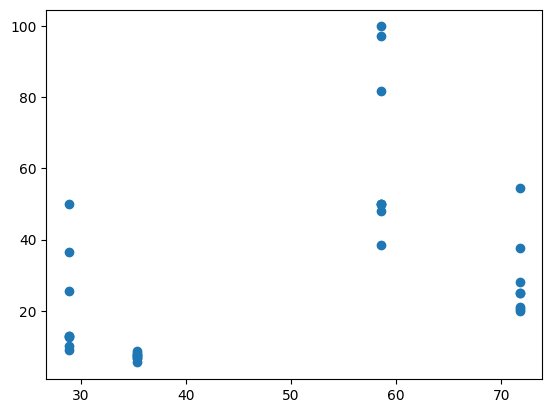

In [180]:
plt.scatter(gaps, mcfp_sol)
kendalltau(gaps, mcfp_sol)

KendalltauResult(correlation=0.06933752452815364, pvalue=0.6053053397590884)

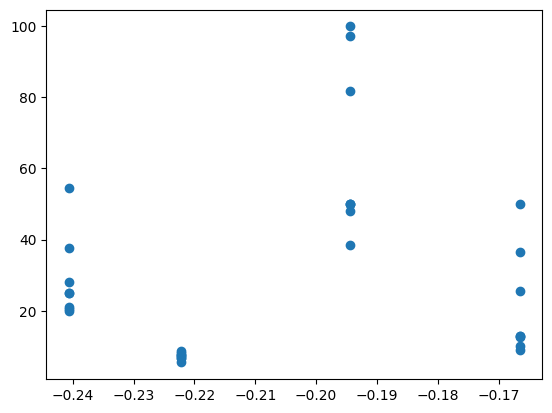

In [181]:
n_eff = [enn_approx(graph, 0.1) for graph, D in graphs_comm]
plt.scatter(n_eff, mcfp_sol)
kendalltau(n_eff, mcfp_sol)

## Conclusion

Spectral gap of the Laplace matrix and effective number of neighbours 
do not correlate with the solution of the MCFP.

__Possible reasons__

1. The proposed metrix do not consider the set of commodities.
2. Additionally, spetral metrics do not consider capacities.



In [182]:
! open .